# PennyLane: Variational classifier with Iris data

Variational circuits are circuits that can be trained using supervised learning or labelled data to classify new data.

The Variational Circuit can be implemented using the Parity Function:

$$
\begin{split}f: x \in \{0,1\}^{\otimes n} \rightarrow y =
\begin{cases} 1 \text{  if uneven number of ones in } x \\ 0
\text{ otherwise} \end{cases}.\end{split}
$$

<img src="images/circuit-centric quantum classifier.png" alt="" />

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

Create quantum device

In [2]:
dev = qml.device("default.qubit", wires=2)
#dev = qml.device("qiskit.aer", wires=2)

## [Step 1] State preparation:
Every input x is translated into a set of angles

> This is amplitude encoding, which literally means you prepare an amplitude vector that resembles your data input.

The statepreparation circuit is coded according to the scheme in this Paper: [Transformation of quantum states using uniformly controlled rotations](https://arxiv.org/abs/quant-ph/0407010)

In [3]:
def get_angles(x):
    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(
        np.sqrt(x[2] ** 2 + x[3] ** 2)
        / np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 + x[3] ** 2)
    )
    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])

def statepreparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

Test the current routine:

In [4]:
x = np.array([0.53896774, 0.79503606, 0.27826503, 0.0], requires_grad=False) # <-- already preprocessed data example (preprocessing will follow below)
ang = get_angles(x)

@qml.qnode(dev)
def test(angles):
    statepreparation(angles)
    return qml.expval(qml.PauliZ(0))

test(ang)

print("x               : ", x)
print("angles          : ", ang)
print("amplitude vector: ", np.real(dev.state))
print(test.draw())

x               :  [0.53896774 0.79503606 0.27826503 0.        ]
angles          :  [ 0.56397465 -0.          0.         -0.97504604  0.97504604]
amplitude vector:  [ 5.38967743e-01  7.95036065e-01  2.78265032e-01 -2.77555756e-17]
 0: ──RY(0.564)──╭C──────────╭C──X──────╭C──────────────╭C──X──────────┤ ⟨Z⟩ 
 1: ─────────────╰X──RY(-0)──╰X──RY(0)──╰X──RY(-0.975)──╰X──RY(0.975)──┤     



Define the layer function:

`qml.Rot(phi, theta, omega, wires)`:

Arbitrary single qubit rotation:
$$
\begin{split}R(\phi,\theta,\omega) = RZ(\omega)RY(\theta)RZ(\phi)= \begin{bmatrix}
e^{-i(\phi+\omega)/2}\cos(\theta/2) & -e^{i(\phi-\omega)/2}\sin(\theta/2) \\
e^{-i(\phi-\omega)/2}\sin(\theta/2) & e^{i(\phi+\omega)/2}\cos(\theta/2)
\end{bmatrix}.\end{split}
$$

In [5]:
def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])

Define `circuit`, variational classifier model, `square_loss`, `cost` and `accuracy` function

In [6]:
@qml.qnode(dev)
def circuit(weights, angles):
    statepreparation(angles)
    for W in weights:
        layer(W)
    return qml.expval(qml.PauliZ(0))

def variational_classifier(var, angles):
    weights = var[0]
    bias = var[1]
    return circuit(weights, angles) + bias

def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2
    loss = loss / len(labels)
    return loss

def cost(weights, features, labels):
    predictions = [variational_classifier(weights, f) for f in features]
    return square_loss(labels, predictions)

def accuracy(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)
    return loss

## Data: Load the Iris data set. 

Link: [iris_classes1and2_scaled.txt](https://raw.githubusercontent.com/XanaduAI/qml/master/demonstrations/variational_classifier/data/iris_classes1and2_scaled.txt)
> The Iris dataset is scaled (by putting zero mean and unit deviation), and classes 1 and 2 were selected.

## Stages of preprocessing
Do some preprocessing withe the iris data:
- Padding:
  - For example x = (x<sub>1</sub>, x<sub>2</sub>, x<sub>3</sub>)<sup>T</sup> would be extended to  x' = (x<sub>1</sub>, x<sub>2</sub>, x<sub>3</sub>, 0)<sup>T</sup>
- Normalization by using the formerly padded X data
- Create features by using `get_angles` function from above unsig the formerly padded and normalized X data

In [8]:
data = np.loadtxt("data/iris_classes1and2_scaled.txt")
X = data[:, 0:2]
print("First X sample (original)  :", X[0])

# pad the vectors to size 2^2 with constant values
padding = 0.3 * np.ones((len(X), 1))
X_pad = np.c_[np.c_[X, padding], np.zeros((len(X), 1))]
print("First X sample (padded)    :", X_pad[0])

# normalize each input
normalization = np.sqrt(np.sum(X_pad ** 2, -1))
X_norm = (X_pad.T / normalization).T
print("First X sample (normalized):", X_norm[0])

# angles for state preparation are new features
# X is renamed to features
features = np.array([get_angles(x) for x in X_norm])
print("First features sample      :", features[0])

Y = data[:, -1]


First X sample (original)  : [0.4  0.75]
First X sample (padded)    : [0.4  0.75 0.3  0.  ]
First X sample (normalized): [0.44376016 0.83205029 0.33282012 0.        ]
First features sample      : [ 0.67858523 -0.          0.         -1.080839    1.080839  ]
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


Stages of preprocessing: plots

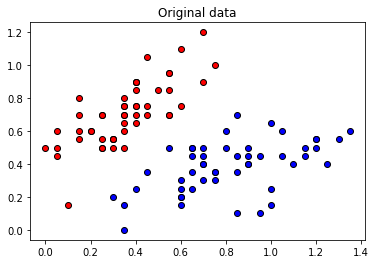

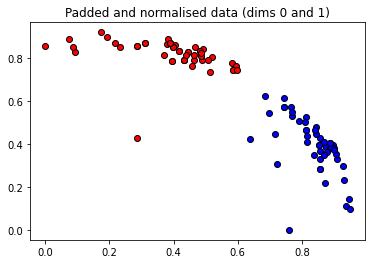

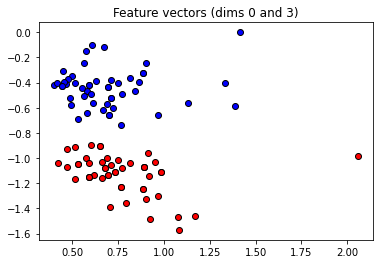

In [9]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="b", marker="o", edgecolors="k")
plt.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="r", marker="o", edgecolors="k")
plt.title("Original data")
plt.show()

plt.figure()
dim1 = 0
dim2 = 1
plt.scatter(
    X_norm[:, dim1][Y == 1], X_norm[:, dim2][Y == 1], c="b", marker="o", edgecolors="k"
)
plt.scatter(
    X_norm[:, dim1][Y == -1], X_norm[:, dim2][Y == -1], c="r", marker="o", edgecolors="k"
)
plt.title("Padded and normalised data (dims {} and {})".format(dim1, dim2))
plt.show()

plt.figure()
dim1 = 0
dim2 = 3
plt.scatter(
    features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="b", marker="o", edgecolors="k"
)
plt.scatter(
    features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="r", marker="o", edgecolors="k"
)
plt.title("Feature vectors (dims {} and {})".format(dim1, dim2))
plt.show()

Split data into training and validation set

In [9]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

Initialize variables

In [10]:
num_qubits = 2
num_layers = 6
var_init = (0.01 * np.random.randn(num_layers, num_qubits, 3), 0.0)

Optimize cost

In [11]:
opt = NesterovMomentumOptimizer(0.01)
batch_size = 5

# train the variational classifier
var = var_init

# Do 60 iterations
for it in range(60):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    var = opt.step(lambda v: cost(v, feats_train_batch, Y_train_batch), var)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(var, f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(var, f)) for f in feats_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, cost(var, features, Y), acc_train, acc_val)
    )

Iter:     1 | Cost: 1.4490948 | Acc train: 0.4933333 | Acc validation: 0.5600000 
Iter:     2 | Cost: 1.3309953 | Acc train: 0.4933333 | Acc validation: 0.5600000 
Iter:     3 | Cost: 1.1582178 | Acc train: 0.4533333 | Acc validation: 0.5600000 
Iter:     4 | Cost: 0.9795035 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     5 | Cost: 0.8857893 | Acc train: 0.6400000 | Acc validation: 0.7600000 
Iter:     6 | Cost: 0.8587935 | Acc train: 0.7066667 | Acc validation: 0.7600000 
Iter:     7 | Cost: 0.8496204 | Acc train: 0.7200000 | Acc validation: 0.6800000 
Iter:     8 | Cost: 0.8200972 | Acc train: 0.7333333 | Acc validation: 0.6800000 
Iter:     9 | Cost: 0.8027511 | Acc train: 0.7466667 | Acc validation: 0.6800000 
Iter:    10 | Cost: 0.7695152 | Acc train: 0.8000000 | Acc validation: 0.7600000 
Iter:    11 | Cost: 0.7437432 | Acc train: 0.8133333 | Acc validation: 0.9600000 
Iter:    12 | Cost: 0.7569196 | Acc train: 0.6800000 | Acc validation: 0.7600000 
Iter:    13 | Co

In [12]:
# if device is "default.qubit"
print(circuit.draw())

# if device is "qiskit.aer"
# dev._circuit.draw(output="mpl") 
# dev._circuit.draw() 

 0: ──RY(0.712)──╭C──────────╭C──X──────╭C──────────────╭C──X──────────Rot(-0.0131, 0.403, -0.00352)───╭C──Rot(-0.0218, 0.429, -0.00737)──╭C──Rot(0.00109, -0.22, 0.00398)──╭C──Rot(-0.00601, 0.423, 0.00977)──╭C──Rot(0.0289, -0.526, 0.0454)──╭C──Rot(0.0262, 0.416, 0.00472)─────╭C──┤ ⟨Z⟩ 
 1: ─────────────╰X──RY(-0)──╰X──RY(0)──╰X──RY(-0.519)──╰X──RY(0.519)──Rot(0.00798, -0.241, -0.00114)──╰X──Rot(-0.0105, 0.766, 0.00341)───╰X──Rot(-0.00111, -0.177, 0.013)──╰X──Rot(0.00425, 0.44, -0.0181)────╰X──Rot(0.0448, -0.107, 0.0334)──╰X──Rot(0.0082, 0.00908, -0.00586)──╰X──┤     



Final Plot of the continuous output of the variational classifier for the first two dimensions of the Iris data set:

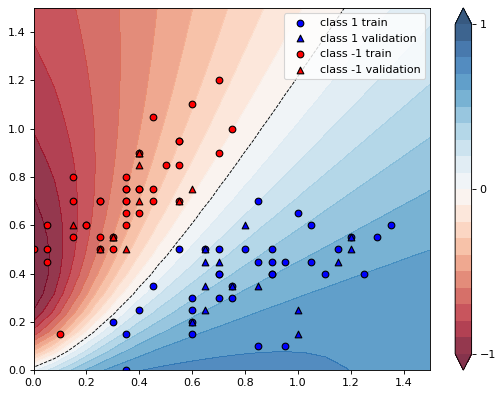

In [13]:
plt.figure(figsize=(8, 6), dpi=80)
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 20), np.linspace(0.0, 1.5, 20))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocess grid points like data inputs above
padding = 0.3 * np.ones((len(X_grid), 1))
X_grid = np.c_[np.c_[X_grid, padding], np.zeros((len(X_grid), 1))]  # pad each input
normalization = np.sqrt(np.sum(X_grid ** 2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array(
    [get_angles(x) for x in X_grid]
)  # angles for state preparation are new features
predictions_grid = [variational_classifier(var, f) for f in features_grid]
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
cnt = plt.contourf(
    xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both"
)
plt.contour(
    xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,)
)
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data
plt.scatter(
    X_train[:, 0][Y_train == 1],
    X_train[:, 1][Y_train == 1],
    c="b",
    marker="o",
    edgecolors="k",
    label="class 1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == 1],
    X_val[:, 1][Y_val == 1],
    c="b",
    marker="^",
    edgecolors="k",
    label="class 1 validation",
)
plt.scatter(
    X_train[:, 0][Y_train == -1],
    X_train[:, 1][Y_train == -1],
    c="r",
    marker="o",
    edgecolors="k",
    label="class -1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == -1],
    X_val[:, 1][Y_val == -1],
    c="r",
    marker="^",
    edgecolors="k",
    label="class -1 validation",
)

plt.legend()
plt.show()

Relevant links & papers:
- https://pennylane.ai/qml/demos/tutorial_variational_classifier.html
- [Circuit-centric quantum classifiers](https://arxiv.org/pdf/1804.00633.pdf)
- [Transformation of quantum states using uniformly controlled rotations](https://arxiv.org/abs/quant-ph/0407010)
- https://pennylane.ai/qml/demos/tutorial_general_parshift.html
